# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import cv2
import os, fnmatch
from tqdm.auto import tqdm
import seaborn as sns

# Para trabajar con ResNet
from torchvision.models import resnet50
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import copy
import random
from   torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import gc
import shutil

# Métricas
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

#Para manipular .rar
import zipfile

# Geopandas
import geopandas as gpd
import networkx as nx
import collections

from tqdm import tqdm
from tqdm.notebook import tqdm
from collections import defaultdict

plt.style.use('ggplot')

In [2]:
import osmnx as ox
ox.config(use_cache=True, log_console=True)

C:\Users\camil\AppData\Local\Temp\ipykernel_1404\4194810668.py:2: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)


In [3]:
from torch_geometric.utils.convert import from_networkx, to_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
from torch_geometric.transforms import FeaturePropagation

In [4]:
import gdown

# ID del archivo de Google Drive
file_id = '1AvxGaBQj02E_ZWWTt3_ATY0uK4VMLH9u'
# URL de descarga directa
url = f'https://drive.google.com/uc?id={file_id}'
# Nombre del archivo que deseas guardar
output = 'imagenes_stgo.zip'  # Cambia la extensión según el archivo

gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1AvxGaBQj02E_ZWWTt3_ATY0uK4VMLH9u
From (redirected): https://drive.google.com/uc?id=1AvxGaBQj02E_ZWWTt3_ATY0uK4VMLH9u&confirm=t&uuid=d932e7fc-61c6-407a-a163-9c66033e4bdd
To: c:\Users\camil\OneDrive - Universidad Católica de Chile\Escritorio\imfd\CrimenCiudad\imagenes_stgo.zip
100%|██████████| 4.07G/4.07G [05:05<00:00, 13.3MB/s]


'imagenes_stgo.zip'

# Fotografías de Santiago

In [5]:
dir_rar = "imagenes_stgo.zip"

Nombre foto 1: imagenes_stgo/-33.36865132,-70.704327184.jpg


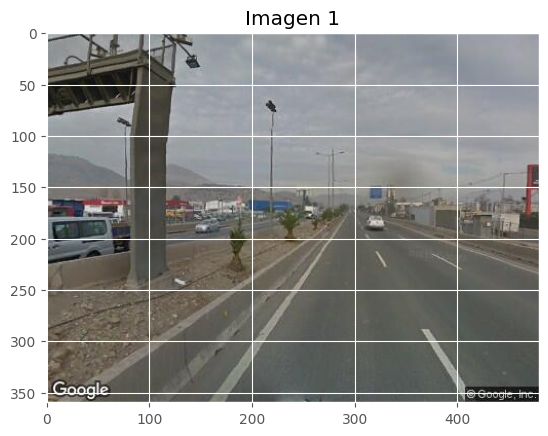

In [6]:
# Definir coordienada latitud y longitud
ejemplo = "imagenes_stgo/-33.36865132,-70.704327184.jpg"
try:
    with zipfile.ZipFile(dir_rar, 'r') as archivo:
        archivo_contents = archivo.namelist() # almacena lista con todos los nombres de las imágenes
        if ejemplo in archivo_contents:
            archivo.extract(ejemplo)
            print(f"Nombre foto 1: {ejemplo}")
        else:
            print(f"Error")

except FileNotFoundError as e:
    print(f"Error: {e}")

img1 = cv2.imread(ejemplo) # cambiar a f"/content/{ejemplo}" si se ejecuta en colab
I1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # Formato imread a formato plt

plt.imshow(I1)
plt.title("Imagen 1")

plt.show()

In [7]:
df_fotos_rar = pd.DataFrame({"nombre_foto": archivo_contents})
print(len(df_fotos_rar))

df_fotos_rar.head()

125921


nombre_foto
0                                   imagenes_stgo/
1  imagenes_stgo/-33.323944,-70.51263428391167.jpg
2         imagenes_stgo/-33.323944,-70.5127291.jpg
3  imagenes_stgo/-33.323944,-70.51298714285714.jpg
4       imagenes_stgo/-33.323944,-70.513436104.jpg

In [8]:
df_fotos = df_fotos_rar.iloc[1:].reset_index(drop=True)
df_fotos_filtro = df_fotos[df_fotos.nombre_foto.str.contains(".jpg")].reset_index(drop=True)

print(len(df_fotos))
df_fotos.head()

125920


nombre_foto
0  imagenes_stgo/-33.323944,-70.51263428391167.jpg
1         imagenes_stgo/-33.323944,-70.5127291.jpg
2  imagenes_stgo/-33.323944,-70.51298714285714.jpg
3       imagenes_stgo/-33.323944,-70.513436104.jpg
4  imagenes_stgo/-33.323944,-70.51379769565217.jpg


En la siguiente función se crearán las columnas latitud y longitud que será necesario para seleccionar puntos en la comuna

In [9]:
def lat_lon(x):
  x = str(x)
  x = x.replace("imagenes_stgo/","")
  x = x.replace(".jpg","")
  latitud, longitud = x.split(",")
  if " " in longitud:
    longitud, _ = longitud.split(" ")
  return latitud, longitud

In [10]:
latitud_list = []
longitud_list = []
for i in df_fotos_filtro.nombre_foto.tolist():
  a, b = lat_lon(i)
  latitud_list.append(a)
  longitud_list.append(b)

In [11]:
df_fotos_filtro["latitud"] = latitud_list
df_fotos_filtro["longitud"] = longitud_list

df_fotos_filtro["latitud"] = df_fotos_filtro["latitud"].astype(float)
df_fotos_filtro["longitud"] = df_fotos_filtro["longitud"].astype(float)

In [12]:
df_fotos_filtro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125380 entries, 0 to 125379
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   nombre_foto  125380 non-null  object 
 1   latitud      125380 non-null  float64
 2   longitud     125380 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.9+ MB


In [13]:
df_fotos_filtro

nombre_foto    latitud  \
0         imagenes_stgo/-33.323944,-70.51263428391167.jpg -33.323944   
1                imagenes_stgo/-33.323944,-70.5127291.jpg -33.323944   
2         imagenes_stgo/-33.323944,-70.51298714285714.jpg -33.323944   
3              imagenes_stgo/-33.323944,-70.513436104.jpg -33.323944   
4         imagenes_stgo/-33.323944,-70.51379769565217.jpg -33.323944   
...                                                   ...        ...   
125375  imagenes_stgo/-33.67884090851735,-70.680595141... -33.678841   
125376  imagenes_stgo/-33.67884090851735,-70.699120236... -33.678841   
125377  imagenes_stgo/-33.67884090851735,-70.706530274... -33.678841   
125378  imagenes_stgo/-33.67884090851735,-70.717645331... -33.678841   
125379  imagenes_stgo/-33.67884090851735,-70.725055369... -33.678841   

         longitud  
0      -70.512634  
1      -70.512729  
2      -70.512987  
3      -70.513436  
4      -70.513798  
...           ...  
125375 -70.680595  
125376 -70.699120  
125377 -70.706530  
125378 -70.717645  
125379 -70.725055  

[125380 rows x 3 columns]

A continuación, se crea la columna geometry.

In [14]:
allpoints = gpd.GeoDataFrame(df_fotos_filtro, geometry=gpd.points_from_xy(df_fotos_filtro["longitud"], df_fotos_filtro["latitud"], crs="EPSG:4326"))

allpoints

nombre_foto    latitud  \
0         imagenes_stgo/-33.323944,-70.51263428391167.jpg -33.323944   
1                imagenes_stgo/-33.323944,-70.5127291.jpg -33.323944   
2         imagenes_stgo/-33.323944,-70.51298714285714.jpg -33.323944   
3              imagenes_stgo/-33.323944,-70.513436104.jpg -33.323944   
4         imagenes_stgo/-33.323944,-70.51379769565217.jpg -33.323944   
...                                                   ...        ...   
125375  imagenes_stgo/-33.67884090851735,-70.680595141... -33.678841   
125376  imagenes_stgo/-33.67884090851735,-70.699120236... -33.678841   
125377  imagenes_stgo/-33.67884090851735,-70.706530274... -33.678841   
125378  imagenes_stgo/-33.67884090851735,-70.717645331... -33.678841   
125379  imagenes_stgo/-33.67884090851735,-70.725055369... -33.678841   

         longitud                     geometry  
0      -70.512634  POINT (-70.51263 -33.32394)  
1      -70.512729  POINT (-70.51273 -33.32394)  
2      -70.512987  POINT (-70.51299 -33.32394)  
3      -70.513436  POINT (-70.51344 -33.32394)  
4      -70.513798  POINT (-70.51380 -33.32394)  
...           ...                          ...  
125375 -70.680595  POINT (-70.68060 -33.67884)  
125376 -70.699120  POINT (-70.69912 -33.67884)  
125377 -70.706530  POINT (-70.70653 -33.67884)  
125378 -70.717645  POINT (-70.71765 -33.67884)  
125379 -70.725055  POINT (-70.72506 -33.67884)  

[125380 rows x 4 columns]

# Cargar datos de delitos

In [15]:
!gdown https://drive.google.com/uc?id=1Bki6zuVe3d32YAHS0FGjO4SlNHP7WzKl

Downloading...
From (original): https://drive.google.com/uc?id=1Bki6zuVe3d32YAHS0FGjO4SlNHP7WzKl
From (redirected): https://drive.google.com/uc?id=1Bki6zuVe3d32YAHS0FGjO4SlNHP7WzKl&confirm=t&uuid=73006a49-7a9e-43c6-b103-9001e41a58cc
To: c:\Users\camil\OneDrive - Universidad Católica de Chile\Escritorio\imfd\CrimenCiudad\delitos_limpio.csv

  0%|          | 0.00/879M [00:00<?, ?B/s]
  0%|          | 1.05M/879M [00:00<01:49, 8.04MB/s]
  0%|          | 2.62M/879M [00:00<01:19, 11.1MB/s]
  0%|          | 4.19M/879M [00:00<01:16, 11.4MB/s]
  1%|          | 5.77M/879M [00:00<01:16, 11.5MB/s]
  1%|          | 7.34M/879M [00:00<01:12, 12.1MB/s]
  1%|          | 9.44M/879M [00:00<01:03, 13.8MB/s]
  1%|▏         | 11.0M/879M [00:00<01:01, 14.2MB/s]
  1%|▏         | 12.6M/879M [00:00<00:59, 14.6MB/s]
  2%|▏         | 14.7M/879M [00:01<00:55, 15.5MB/s]
  2%|▏         | 16.8M/879M [00:01<00:53, 16.1MB/s]
  2%|▏         | 19.4M/879M [00:01<00:46, 18.4MB/s]
  2%|▏         | 21.5M/879M [00:01<00:44, 1

In [26]:
import pandas as pd
import geopandas as gpd
from unidecode import unidecode

csv_file_path = 'delitos_limpio.csv'
df = pd.read_csv(csv_file_path)
df['x'] = df['x'].astype(float).round(5)
df['y'] = df['y'].astype(float).round(5)
gdf_delitos = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))
gdf_delitos.drop(columns=['index'], inplace=True)
gdf_delitos['comuna'] = gdf_delitos['comuna'].apply(unidecode)
gdf_delitos

x         y  parte_id       fecha      hora        rango  \
0       -70.94693 -33.45823    394474  2015-07-31  08:30:00   8:00-11:59   
1       -70.93741 -33.47525  12796554  2021-11-05  19:40:00  16:00-19:59   
2       -70.93700 -33.45689    148692  2016-05-02  11:40:00   8:00-11:59   
3       -70.93700 -33.45689   5022545  2017-08-05  06:30:00    4:00-7:59   
4       -70.93699 -33.47530  13108530  2022-01-07  22:05:00  20:00-23:59   
...           ...       ...       ...         ...       ...          ...   
4418603 -70.24862 -33.35785  12586668  2021-08-13  10:00:00   8:00-11:59   
4418604 -70.24830 -33.35292   8866623  2019-09-18  03:40:00    0:00-3:59   
4418605 -70.24821 -33.35332   8866628  2019-09-21  18:35:00  16:00-19:59   
4418606 -70.21296 -33.24963   9829539  2020-01-11  10:00:00   8:00-11:59   
4418607 -69.75476 -31.84691   6477192  2017-10-29  13:00:00  12:00-15:59   

        clasificacion_parte         source   source_glosa  estado  ...  \
0                  Denuncia  caso_policial  Caso policial     NaN  ...   
1                  Denuncia  caso_policial  Caso policial     NaN  ...   
2                  Denuncia  caso_policial  Caso policial     NaN  ...   
3                  Denuncia  caso_policial  Caso policial     NaN  ...   
4                  Denuncia  caso_policial  Caso policial     NaN  ...   
...                     ...            ...            ...     ...  ...   
4418603            Denuncia  caso_policial  Caso policial     NaN  ...   
4418604           Detención  caso_policial  Caso policial     NaN  ...   
4418605           Detención  caso_policial  Caso policial     NaN  ...   
4418606            Denuncia  caso_policial  Caso policial     NaN  ...   
4418607            Denuncia  caso_policial  Caso policial     NaN  ...   

                                    delito riesgo_situacional  \
0               Robo vehículos motorizados                NaN   
1                     Hallazgo de vehículo                NaN   
2                           Lesiones leves                NaN   
3                                    Daños                NaN   
4        Robo con violencia o intimidación                NaN   
...                                    ...                ...   
4418603             Robo en lugar habitado                NaN   
4418604                     Lesiones leves                NaN   
4418605          Robo en lugar no habitado                NaN   
4418606          Robo en lugar no habitado                NaN   
4418607                              Hurto                NaN   

        descripcion_situacional  denuncia_formal  denuncia_informa  \
0                           NaN              NaN               NaN   
1                           NaN              NaN               NaN   
2                           NaN              NaN               NaN   
3                           NaN              NaN               NaN   
4                           NaN              NaN               NaN   
...                         ...              ...               ...   
4418603                     NaN              NaN               NaN   
4418604                     NaN              NaN               NaN   
4418605                     NaN              NaN               NaN   
4418606                     NaN              NaN               NaN   
4418607                     NaN              NaN               NaN   

               comuna  id_comuna barrio  id_barrio  \
0            Pudahuel      13124    NaN        NaN   
1            Pudahuel      13124    NaN        NaN   
2            Pudahuel      13124    NaN        NaN   
3            Pudahuel      13124    NaN        NaN   
4            Pudahuel      13124    NaN        NaN   
...               ...        ...    ...        ...   
4418603  Lo Barnechea      13115    NaN        NaN   
4418604  Lo Barnechea      13115    NaN        NaN   
4418605  Lo Barnechea      13115    NaN        NaN   
4418606  Lo Barnechea      13115    NaN        NaN  

In [32]:
gdf_delitos[gdf_delitos.comuna == 'Cerrillos'].drop_duplicates(subset='parte_id')

x         y  parte_id       fecha      hora        rango  \
547960  -70.73961 -33.51010    352936  2015-07-26  13:30:00  12:00-15:59   
547961  -70.73961 -33.51010    777874  2014-06-19  08:40:00   8:00-11:59   
547962  -70.73961 -33.51010    916204  2013-06-23  04:19:00    4:00-7:59   
547963  -70.73961 -33.51010    964634  2014-06-01  12:00:00  12:00-15:59   
547964  -70.73961 -33.51010   1684996  2013-10-31  13:20:00  12:00-15:59   
...           ...       ...       ...         ...       ...          ...   
1210828 -70.68567 -33.47814   9508545  2019-11-19  11:15:00   8:00-11:59   
1211063 -70.68565 -33.47833   3850275  2015-04-16  12:30:00  12:00-15:59   
1212937 -70.68553 -33.47892   4829418  2017-08-19  00:20:00    0:00-3:59   
1212938 -70.68553 -33.47892   7409994  2018-09-12  07:25:00    4:00-7:59   
1214682 -70.68548 -33.47832   3658670  2016-04-18  19:50:00  16:00-19:59   

        clasificacion_parte         source   source_glosa  estado  ...  \
547960             Denuncia  caso_policial  Caso policial     NaN  ...   
547961             Denuncia  caso_policial  Caso policial     NaN  ...   
547962             Denuncia  caso_policial  Caso policial     NaN  ...   
547963             Denuncia  caso_policial  Caso policial     NaN  ...   
547964             Denuncia  caso_policial  Caso policial     NaN  ...   
...                     ...            ...            ...     ...  ...   
1210828            Denuncia  caso_policial  Caso policial     NaN  ...   
1211063            Denuncia  caso_policial  Caso policial     NaN  ...   
1212937            Denuncia  caso_policial  Caso policial     NaN  ...   
1212938            Denuncia  caso_policial  Caso policial     NaN  ...   
1214682            Denuncia  caso_policial  Caso policial     NaN  ...   

                                      delito riesgo_situacional  \
547960                                 Hurto                NaN   
547961                        Lesiones leves                NaN   
547962                  Hallazgo de vehículo                NaN   
547963               Amenaza (incivilidades)                NaN   
547964   Especies abandonadas en vía pública                NaN   
...                                      ...                ...   
1210828    Robo con violencia o intimidación                NaN   
1211063    Robo con violencia o intimidación                NaN   
1212937    Robo con violencia o intimidación                NaN   
1212938                                Daños                NaN   
1214682            Robo en lugar no habitado                NaN   

        descripcion_situacional  denuncia_formal  denuncia_informa     comuna  \
547960                      NaN              NaN               NaN  Cerrillos   
547961                      NaN              NaN               NaN  Cerrillos   
547962                      NaN              NaN               NaN  Cerrillos   
547963                      NaN              NaN               NaN  Cerrillos   
547964                      NaN              NaN               NaN  Cerrillos   
...                         ...              ...               ...        ...   
1210828                     NaN              NaN               NaN  Cerrillos   
1211063                     NaN              NaN               NaN  Cerrillos   
1212937                     NaN              NaN               NaN  Cerrillos   
1212938                     NaN              NaN               NaN  Cerrillos   
1214682                     NaN              NaN               NaN  Cerrillos   

         id_comuna barrio  id_barrio                     geometry  
547960       13102    NaN        NaN  POINT (-70.73961 -33.51010)  
547961       13102    NaN        NaN  POINT (-70.73961 -33.51010)  
547962       13102    NaN        NaN  POINT (-70.73961 -33.51010)  
547963       13102    NaN        NaN  POINT (-70.73961 -33.51010)  
547964       13102    NaN        NaN  POINT (-70.73961 -33.51010)  
...            ...    ...   

# Crear de grafo con Open Street Map

In [20]:
# Lista de comunas de Santiago, Chile en el formato solicitado
comunas = [
    "Cerrillos, Chile",
    "Cerro Navia, Chile",
    "Conchali, Chile",
    "El Bosque, Chile",
    "Estacion Central, Chile",
    "Huechuraba, Chile",
    "Independencia, Chile",
    "La Cisterna, Chile",
    "La Florida, Chile",
    "La Granja, Chile",
    "La Pintana, Chile",
    "La Reina, Chile",
    "Las Condes, Chile",
    "Lo Barnechea, Chile",
    "Lo Espejo, Chile",
    "Lo Prado, Chile",
    "Macul, Chile",
    "Maipu, Chile",
    "Nunoa, Chile",
    "Pedro Aguirre Cerda, Chile",
    "Penalolen, Chile",
    "Providencia, Chile",
    "Pudahuel, Chile",
    "Quilicura, Chile",
    "Quinta Normal, Chile",
    "Recoleta, Chile",
    "Renca, Chile",
    "San Miguel, Chile",
    "San Ramon, Chile",
    "Santiago, Chile",
    "Vitacura, Chile"
]

C:\Users\camil\AppData\Local\Temp\ipykernel_1404\3248967983.py:1: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)


Cerrillos, Chile


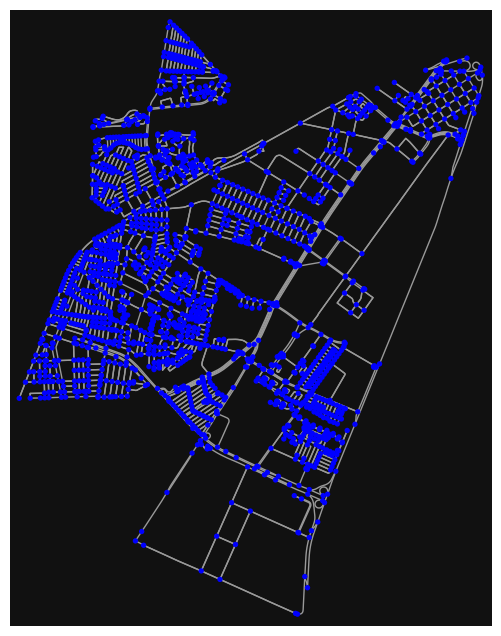

(1, 17)
Cerro Navia, Chile


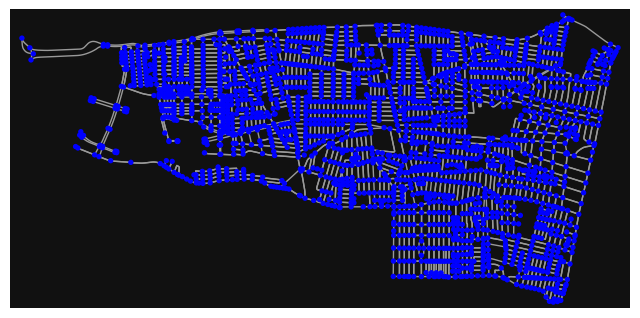

(1, 17)
Conchali, Chile


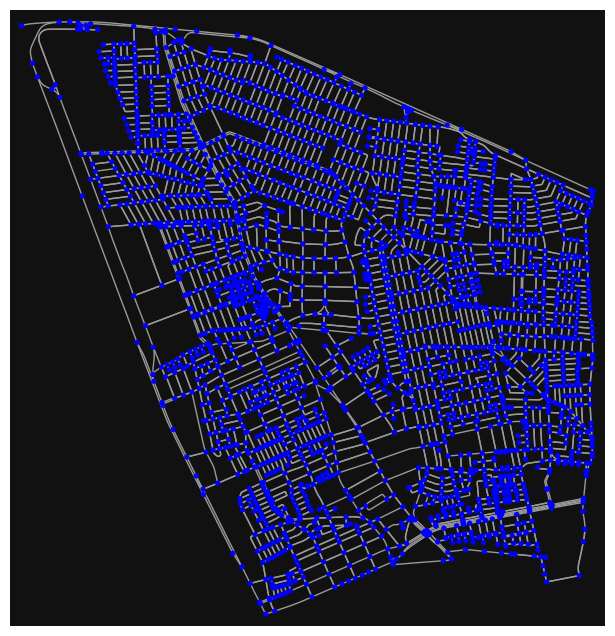

(1, 17)
El Bosque, Chile


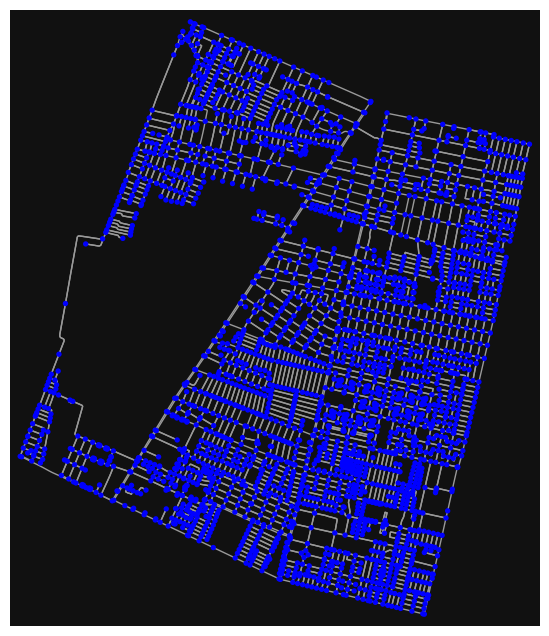

(1, 17)
Estacion Central, Chile


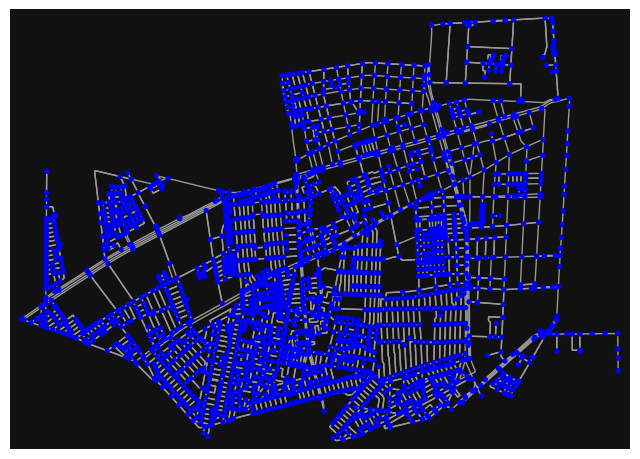

(1, 17)
Huechuraba, Chile


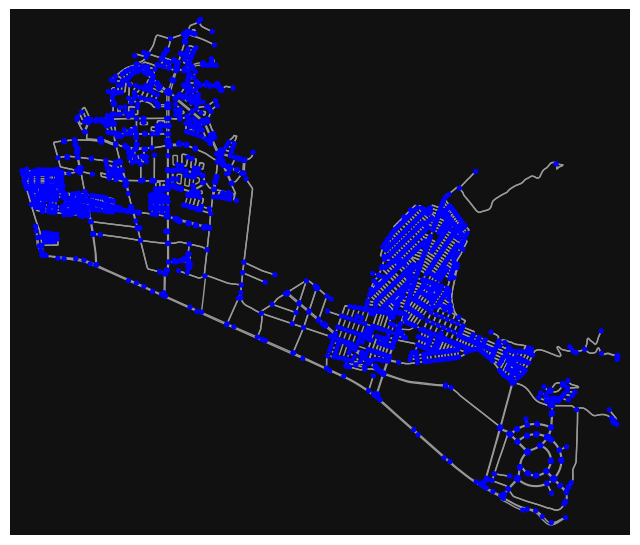

(1, 17)
Independencia, Chile


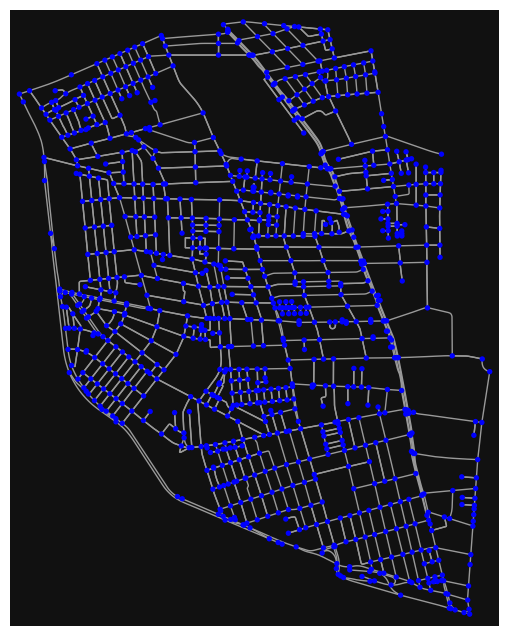

(1, 17)
La Cisterna, Chile


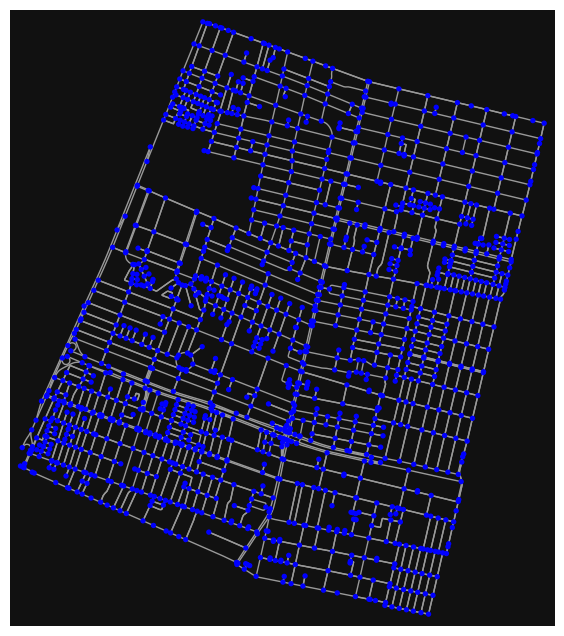

(1, 17)
La Florida, Chile


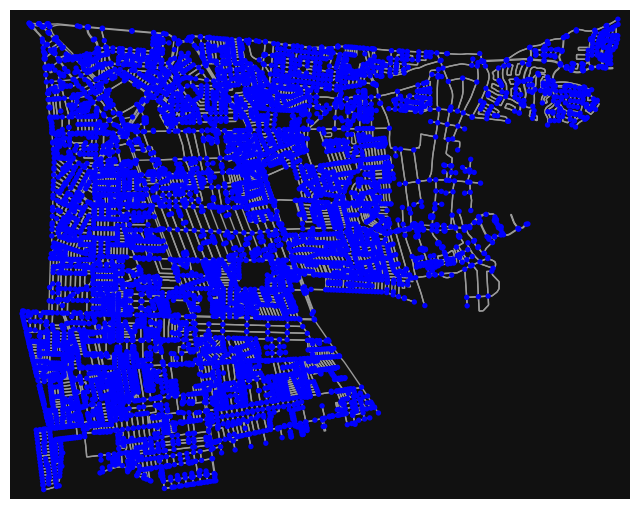

(1, 17)
La Granja, Chile


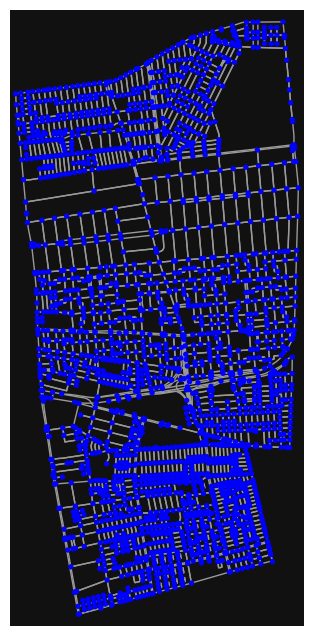

(1, 17)
La Pintana, Chile


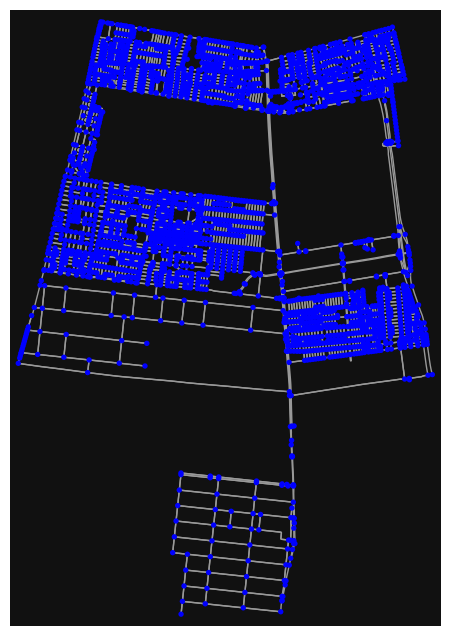

(1, 17)
La Reina, Chile


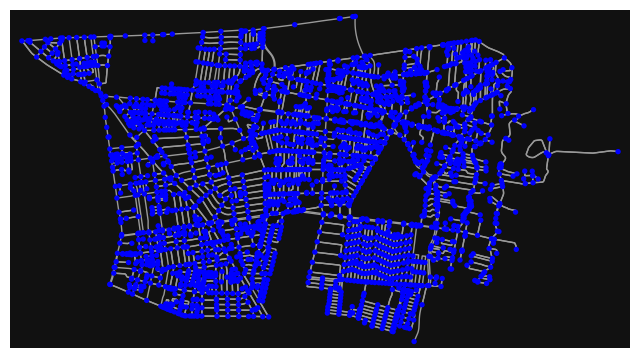

(1, 17)
Las Condes, Chile


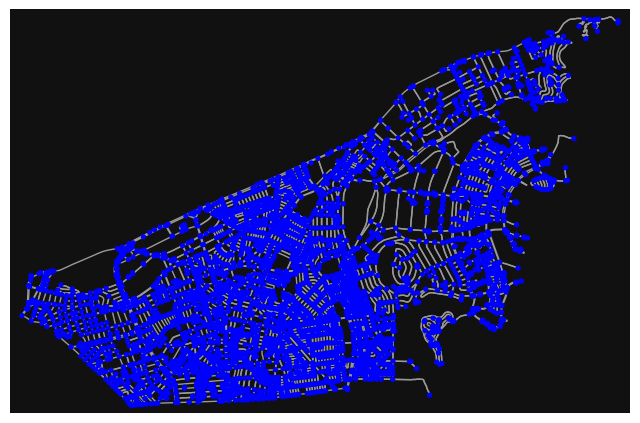

(1, 17)
Lo Barnechea, Chile


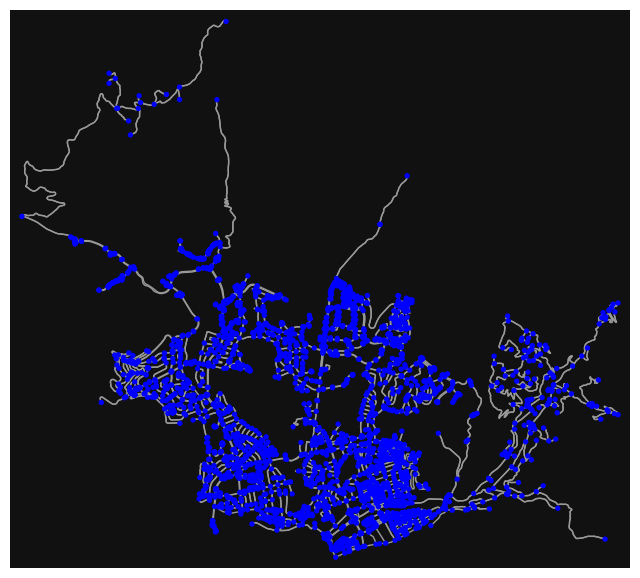

(1, 17)
Lo Espejo, Chile


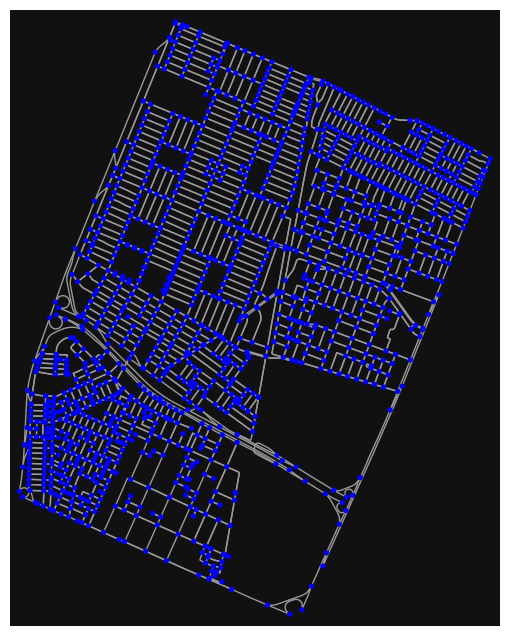

(1, 17)
Lo Prado, Chile


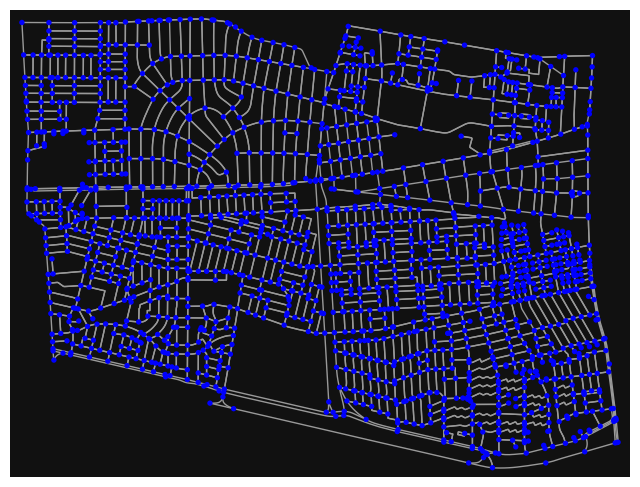

(1, 17)
Macul, Chile


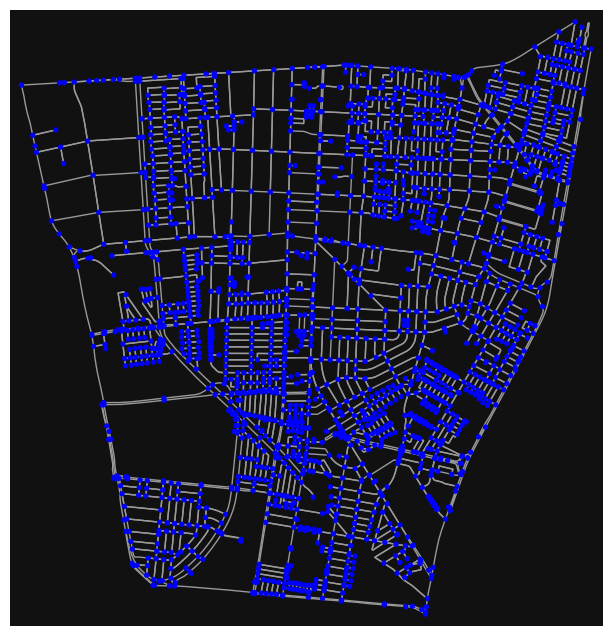

(1, 17)
Maipu, Chile


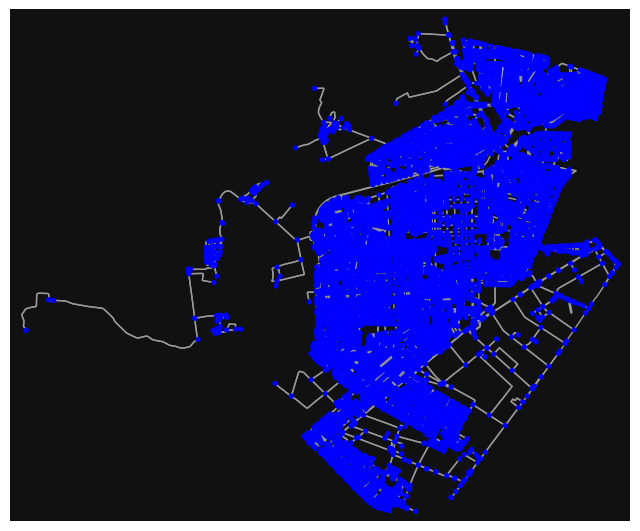

(1, 17)
Nunoa, Chile


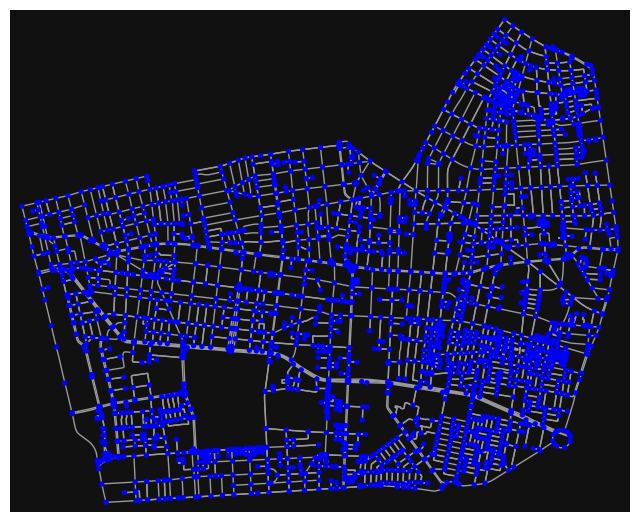

(1, 17)
Pedro Aguirre Cerda, Chile


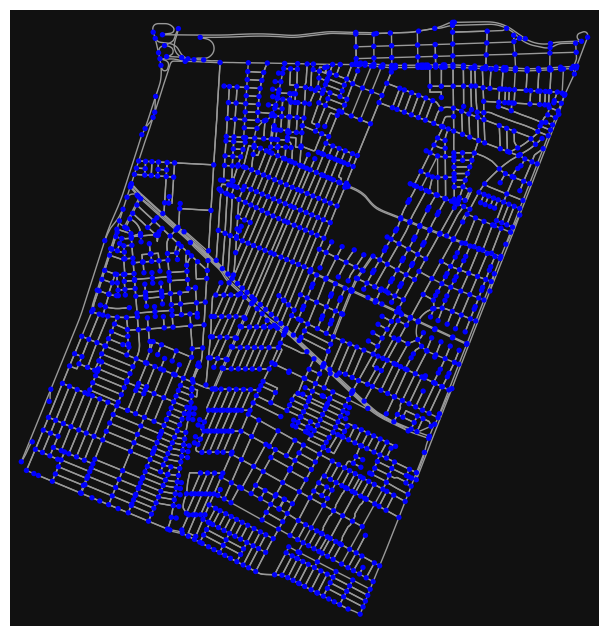

(1, 17)
Penalolen, Chile


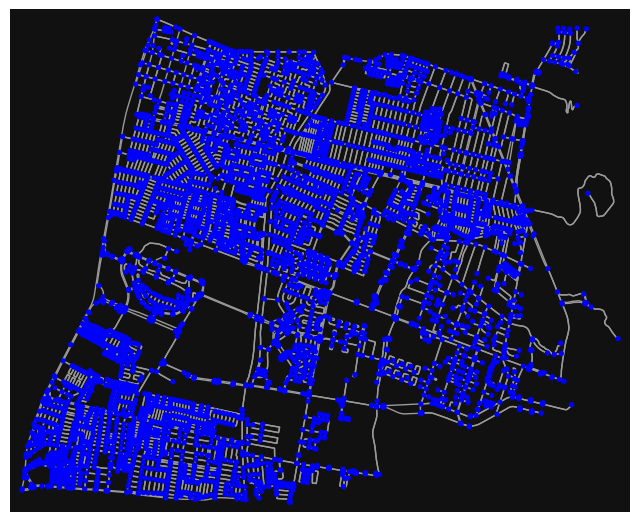

(1, 17)
Providencia, Chile


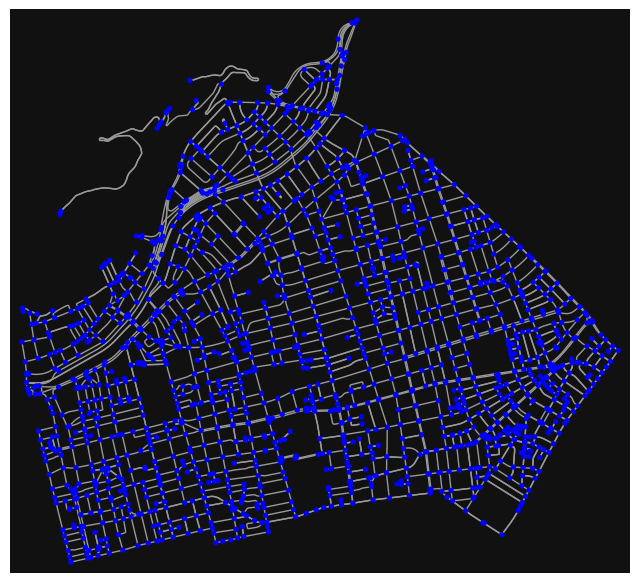

(1, 17)
Pudahuel, Chile


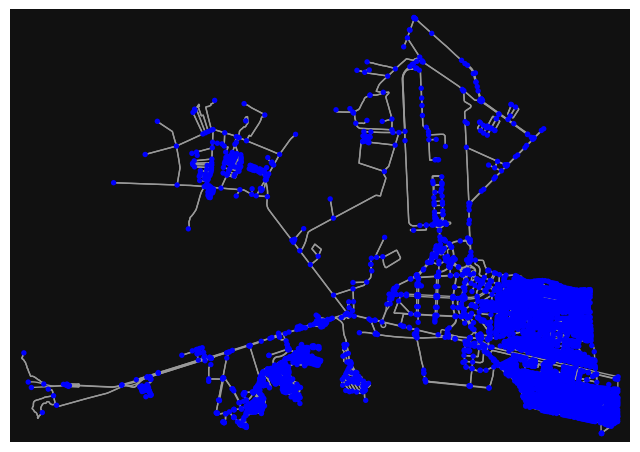

(1, 17)
Quilicura, Chile


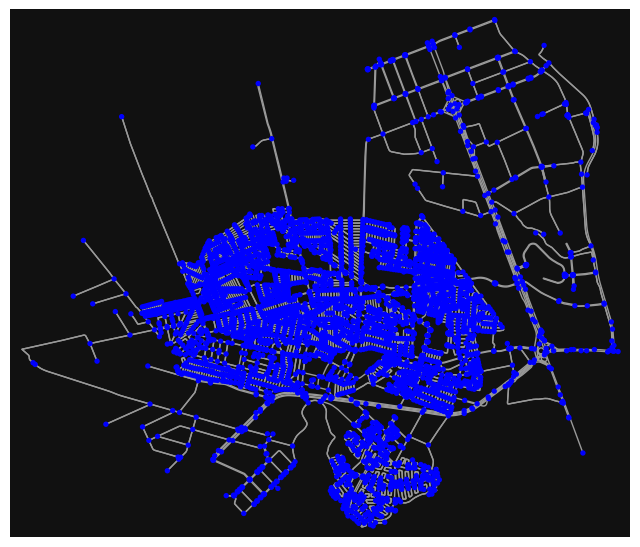

(1, 17)
Quinta Normal, Chile


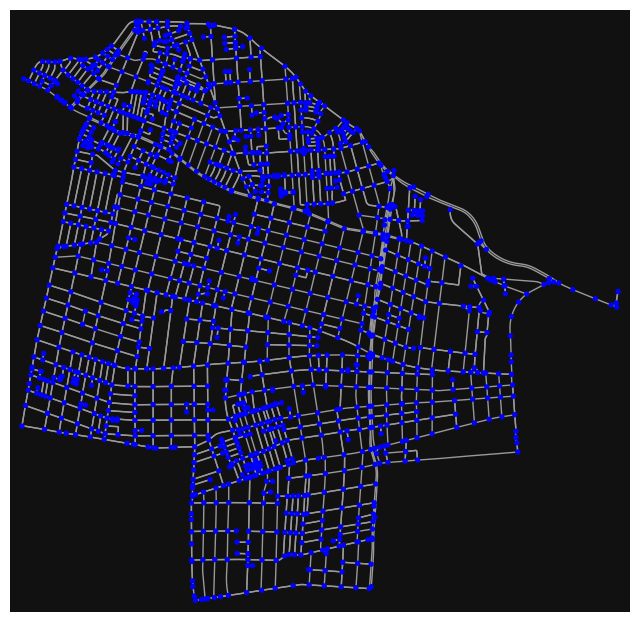

(1, 17)
Recoleta, Chile


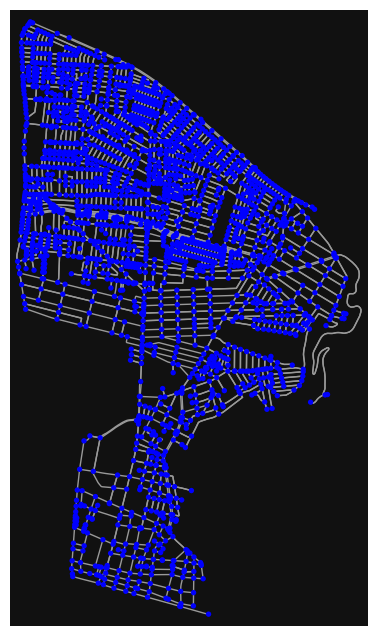

(1, 17)
Renca, Chile


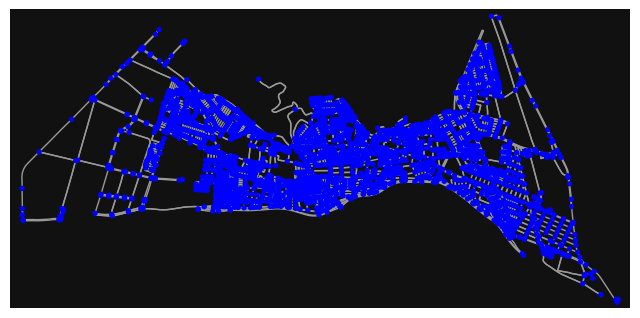

(1, 17)
San Miguel, Chile


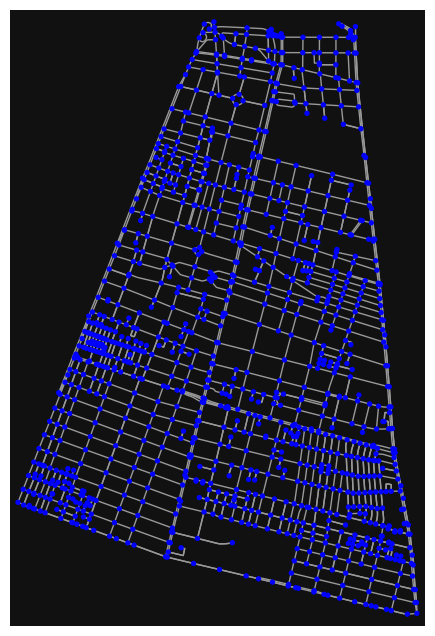

(1, 17)
San Ramon, Chile


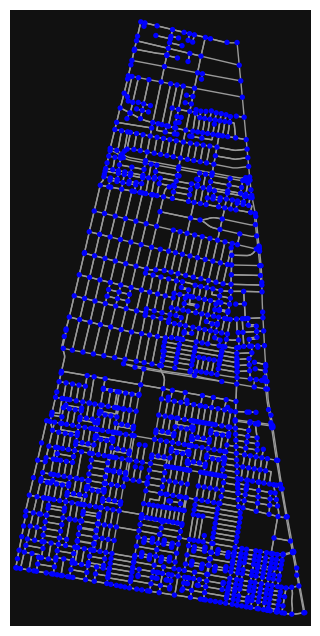

(1, 17)
Santiago, Chile


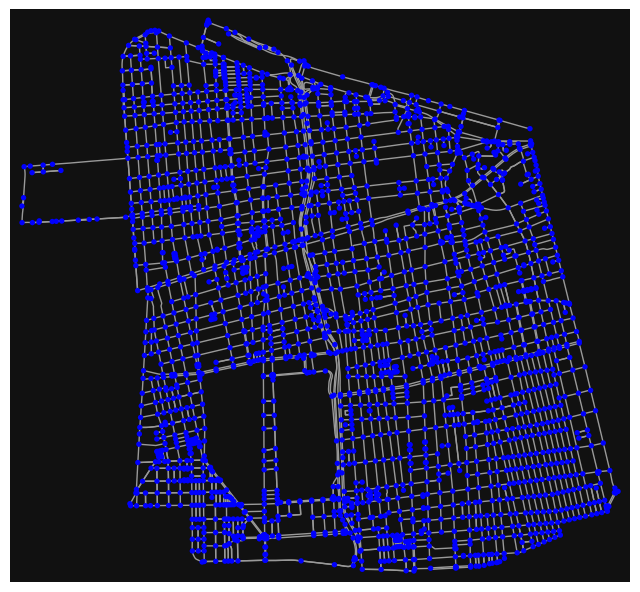

(1, 17)
Vitacura, Chile


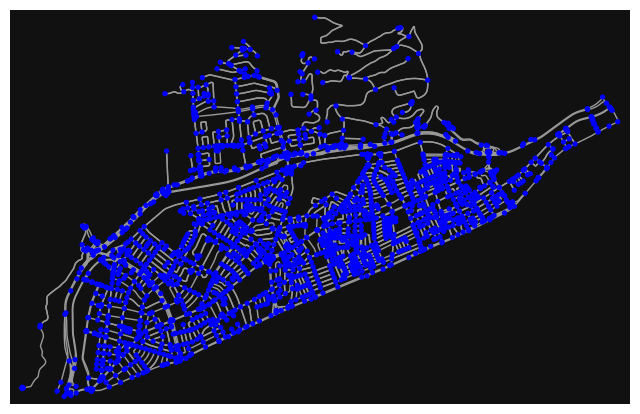

(1, 17)


In [45]:
ox.config(use_cache=True, log_console=True)
from tqdm import tqdm

info_comunas = {}

for comuna in comunas:
  print(comuna)
  cf = '["highway"~"primary"]'
  G = ox.graph_from_place(comuna, network_type='drive')
  ox.plot_graph(G, node_color="blue", node_size=15)
  nombre_comuna = comuna.split(',')[0]
  gdf_comuna = ox.geocode_to_gdf(comuna)
  print(gdf_comuna.shape)
  info_comunas[nombre_comuna] = {
    'gdf': gdf_comuna,
    'grafo': G
  }

# Encontrar imágenes más cercanas

Ahora se encontrará el nodo más cercano a cada imagen. Este proceso toma 30 minutos, aproximadamente.

In [22]:
import osmnx as ox
from shapely.geometry import Point

def get_nearest_node_within_boundary(G, gdf, point):
    # Verificar si el punto está vacío
    if point.is_empty:
        return None

    # Obtener la geometría de la comuna
    geom = gdf.loc[0, 'geometry']

    # Verificar si el punto está dentro de la comuna
    if geom.intersects(point):
        # Obtener el nodo más cercano solo si el punto está dentro de la comuna
        return ox.distance.nearest_nodes(G, point.x, point.y)

    return None

In [23]:
def filter_points_within_comuna(gdf_points, gdf_comuna):
    # Obtener la geometría de la comuna
    comuna_geom = gdf_comuna.loc[0, 'geometry']

    # Filtrar puntos que están dentro de la comuna
    filtered_points = gdf_points[gdf_points['geometry'].apply(lambda point: comuna_geom.intersects(point))]

    return filtered_points

In [63]:
from tqdm import tqdm
import os
import gc

tqdm.pandas()

# Asegúrate de que tqdm está configurado para el progreso
pd.options.mode.chained_assignment = None  # para evitar advertencias

def process_comuna(nombre_comuna, info_comuna, gdf_delitos, allpoints, output_dir):

    G = info_comuna['grafo']
    gdf_comuna = info_comuna['gdf']

    print(f'Procesando comuna: {nombre_comuna}')
    
    # Verificar si el archivo delitos_imagenes_{nombre_comuna}.csv ya existe
    output_file = os.path.join(output_dir, f'delitos_imagenes_{nombre_comuna}.csv')
    if os.path.exists(output_file):
        print(f'El archivo {output_file} ya existe. No es necesario procesar esta comuna.')
        return None
    
    delitos_comuna = gdf_delitos[gdf_delitos['comuna'] == nombre_comuna].reset_index(drop=True)
    print(f'Para el periodo, se cometieron {delitos_comuna.shape} en esta comuna.')
    
    puntos_unicos_delitos_comuna = delitos_comuna[['geometry']].drop_duplicates(subset='geometry').reset_index(drop=True)
    print(f'Hay {len(puntos_unicos_delitos_comuna)} puntos únicos de delitos.')

    puntos_unicos_delitos_comuna['nearest_node'] = puntos_unicos_delitos_comuna['geometry'].progress_apply(
        lambda point: get_nearest_node_within_boundary(G, gdf_comuna, point)
    )
    print(f'Calculado nearest_node para puntos únicos de delitos.')

    imagenes_comuna = filter_points_within_comuna(allpoints, gdf_comuna)
    imagenes_comuna["nearest_node"] = imagenes_comuna['geometry'].progress_apply(
        lambda point: get_nearest_node_within_boundary(G, gdf_comuna, point)
    )
    print(f'Calculado nearest_node para imágenes.')

    # Merge de puntos_unicos_delitos_comuna con imagenes_comuna
    puntos_unicos_delitos_imagenes = puntos_unicos_delitos_comuna.merge(imagenes_comuna[['nombre_foto', 'nearest_node']], 
                                                                        how='left', on='nearest_node')
    print(f'Merge de puntos únicos de delitos con imagenes completado: {puntos_unicos_delitos_imagenes.shape}.')

    # Procesamiento por lotes para merge
    batch_size = 10000
    
    dataframes_batches = []
    
    header_written = False
    
    counter = 0
    for start in range(0, len(puntos_unicos_delitos_imagenes), batch_size):
        end = start + batch_size
        batch = puntos_unicos_delitos_imagenes.iloc[start:end]
        batch_merge = delitos_comuna.merge(batch, how='left', on='geometry')
        
        # Guardar cada lote en el archivo CSV
        batch_merge.to_csv(output_file, mode='a', header=not header_written, index=False)
        header_written = True

        # Agregar el batch_merge a la lista de DataFrames
        dataframes_batches.append(batch_merge)

        del batch_merge
        gc.collect()
        counter += 1
        print(f'En total, se han escrito {counter} batch en el archivo {output_file}.')
    
    print(f'Procesamiento completado para la comuna {nombre_comuna}.')
    delitos_comuna_final = pd.concat(dataframes_batches, ignore_index=True)
    return delitos_comuna_final

In [64]:
# Definir directorio de salida
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# Supongamos que G y gdfs_comunas están definidos, y gdf_delitos es tu DataFrame de delitos
for nombre_comuna, info_comuna in info_comunas.items():
    print(nombre_comuna)
    delitos_comuna_final = process_comuna(nombre_comuna, info_comuna, gdf_delitos, allpoints, output_dir)

Cerrillos
Procesando comuna: Cerrillos
El archivo output\delitos_imagenes_Cerrillos.csv ya existe. No es necesario procesar esta comuna.
Cerro Navia
Procesando comuna: Cerro Navia
Para el periodo, se cometieron (77782, 22) en esta comuna.
Hay 20851 puntos únicos de delitos.


100%|██████████| 20851/20851 [04:03<00:00, 85.66it/s] 


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2083/2083 [00:24<00:00, 86.51it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (28711, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Cerro Navia.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Cerro Navia.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Cerro Navia.csv.
Procesamiento completado para la comuna Cerro Navia.
Conchali
Procesando comuna: Conchali
Para el periodo, se cometieron (91403, 22) en esta comuna.
Hay 22175 puntos únicos de delitos.


100%|██████████| 22175/22175 [04:20<00:00, 85.09it/s] 


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2361/2361 [00:26<00:00, 89.46it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (34997, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Conchali.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Conchali.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Conchali.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Conchali.csv.
Procesamiento completado para la comuna Conchali.
El Bosque
Procesando comuna: El Bosque
Para el periodo, se cometieron (104765, 22) en esta comuna.
Hay 26886 puntos únicos de delitos.


100%|██████████| 26886/26886 [05:58<00:00, 75.00it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2494/2494 [00:34<00:00, 72.17it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (38614, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_El Bosque.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_El Bosque.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_El Bosque.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_El Bosque.csv.
Procesamiento completado para la comuna El Bosque.
Estacion Central
Procesando comuna: Estacion Central
Para el periodo, se cometieron (184485, 22) en esta comuna.
Hay 25297 puntos únicos de delitos.


100%|██████████| 25297/25297 [04:59<00:00, 84.37it/s] 


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2636/2636 [00:31<00:00, 83.53it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (50443, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Estacion Central.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Estacion Central.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Estacion Central.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Estacion Central.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Estacion Central.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_Estacion Central.csv.
Procesamiento completado para la comuna Estacion Central.
Huechuraba
Procesando comuna: Huechuraba
Para el periodo, se cometieron (76657, 22) en esta comuna.
Hay 15584 puntos únicos de delitos.


100%|██████████| 15584/15584 [02:53<00:00, 89.80it/s] 


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2545/2545 [00:29<00:00, 86.27it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (33811, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Huechuraba.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Huechuraba.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Huechuraba.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Huechuraba.csv.
Procesamiento completado para la comuna Huechuraba.
Independencia
Procesando comuna: Independencia
Para el periodo, se cometieron (85651, 22) en esta comuna.
Hay 15420 puntos únicos de delitos.


100%|██████████| 15420/15420 [02:04<00:00, 124.01it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 1435/1435 [00:11<00:00, 129.13it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (33327, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Independencia.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Independencia.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Independencia.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Independencia.csv.
Procesamiento completado para la comuna Independencia.
La Cisterna
Procesando comuna: La Cisterna
Para el periodo, se cometieron (80457, 22) en esta comuna.
Hay 17040 puntos únicos de delitos.


100%|██████████| 17040/17040 [02:32<00:00, 111.75it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2077/2077 [00:21<00:00, 95.57it/s] 


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (37866, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_La Cisterna.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_La Cisterna.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_La Cisterna.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_La Cisterna.csv.
Procesamiento completado para la comuna La Cisterna.
La Florida
Procesando comuna: La Florida
Para el periodo, se cometieron (285928, 22) en esta comuna.
Hay 56326 puntos únicos de delitos.


100%|██████████| 56326/56326 [30:17<00:00, 31.00it/s]  


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 7247/7247 [03:48<00:00, 31.65it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (90093, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_La Florida.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_La Florida.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_La Florida.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_La Florida.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_La Florida.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_La Florida.csv.
En total, se han escrito 7 batch en el archivo output\delitos_imagenes_La Florida.csv.
En total, se han escrito 8 batch en el archivo output\delitos_imagenes_La Florida.csv.
En total, se han escrito 9 batch en el archivo output\delitos_imagenes_La Florida.csv.
En total, se han escrito 10 batch en el archivo output\delitos_imagenes_La Florida.csv.
Procesamiento comple

100%|██████████| 22084/22084 [03:44<00:00, 98.44it/s] 


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2093/2093 [00:20<00:00, 103.36it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (36822, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_La Granja.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_La Granja.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_La Granja.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_La Granja.csv.
Procesamiento completado para la comuna La Granja.
La Pintana
Procesando comuna: La Pintana
Para el periodo, se cometieron (119375, 22) en esta comuna.
Hay 31662 puntos únicos de delitos.


100%|██████████| 31662/31662 [06:25<00:00, 82.12it/s] 


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 3252/3252 [00:40<00:00, 80.16it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (56519, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_La Pintana.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_La Pintana.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_La Pintana.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_La Pintana.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_La Pintana.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_La Pintana.csv.
Procesamiento completado para la comuna La Pintana.
La Reina
Procesando comuna: La Reina
Para el periodo, se cometieron (74795, 22) en esta comuna.
Hay 17426 puntos únicos de delitos.


100%|██████████| 17426/17426 [03:26<00:00, 84.35it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2756/2756 [00:32<00:00, 84.52it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (32496, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_La Reina.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_La Reina.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_La Reina.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_La Reina.csv.
Procesamiento completado para la comuna La Reina.
Las Condes
Procesando comuna: Las Condes
Para el periodo, se cometieron (199260, 22) en esta comuna.
Hay 32348 puntos únicos de delitos.


100%|██████████| 32348/32348 [09:58<00:00, 54.05it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 7446/7446 [02:18<00:00, 53.87it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (77148, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Las Condes.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Las Condes.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Las Condes.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Las Condes.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Las Condes.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_Las Condes.csv.
En total, se han escrito 7 batch en el archivo output\delitos_imagenes_Las Condes.csv.
En total, se han escrito 8 batch en el archivo output\delitos_imagenes_Las Condes.csv.
Procesamiento completado para la comuna Las Condes.
Lo Barnechea
Procesando comuna: Lo Barnechea
Para el periodo, se cometieron (50409, 22) en esta comuna.
Hay 13364 puntos únicos de delitos.


100%|██████████| 13364/13364 [02:43<00:00, 81.59it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 3587/3587 [00:44<00:00, 80.02it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (33415, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Lo Barnechea.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Lo Barnechea.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Lo Barnechea.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Lo Barnechea.csv.
Procesamiento completado para la comuna Lo Barnechea.
Lo Espejo
Procesando comuna: Lo Espejo
Para el periodo, se cometieron (62558, 22) en esta comuna.
Hay 16029 puntos únicos de delitos.


100%|██████████| 16029/16029 [02:12<00:00, 120.76it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 1618/1618 [00:13<00:00, 122.35it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (26523, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Lo Espejo.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Lo Espejo.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Lo Espejo.csv.
Procesamiento completado para la comuna Lo Espejo.
Lo Prado
Procesando comuna: Lo Prado
Para el periodo, se cometieron (71941, 22) en esta comuna.
Hay 13875 puntos únicos de delitos.


100%|██████████| 13875/13875 [02:01<00:00, 114.14it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 1419/1419 [00:12<00:00, 114.84it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (19671, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Lo Prado.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Lo Prado.csv.
Procesamiento completado para la comuna Lo Prado.
Macul
Procesando comuna: Macul
Para el periodo, se cometieron (82741, 22) en esta comuna.
Hay 17298 puntos únicos de delitos.


100%|██████████| 17298/17298 [03:00<00:00, 95.97it/s] 


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2502/2502 [00:26<00:00, 93.08it/s] 


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (32520, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Macul.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Macul.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Macul.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Macul.csv.
Procesamiento completado para la comuna Macul.
Maipu
Procesando comuna: Maipu
Para el periodo, se cometieron (290952, 22) en esta comuna.
Hay 72875 puntos únicos de delitos.


100%|██████████| 72875/72875 [57:00<00:00, 21.30it/s]  


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 9704/9704 [07:37<00:00, 21.20it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (107173, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Maipu.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Maipu.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Maipu.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Maipu.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Maipu.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_Maipu.csv.
En total, se han escrito 7 batch en el archivo output\delitos_imagenes_Maipu.csv.
En total, se han escrito 8 batch en el archivo output\delitos_imagenes_Maipu.csv.
En total, se han escrito 9 batch en el archivo output\delitos_imagenes_Maipu.csv.
En total, se han escrito 10 batch en el archivo output\delitos_imagenes_Maipu.csv.
En total, se han escrito 11 batch en el archivo output\delitos_imagen

100%|██████████| 25094/25094 [04:32<00:00, 92.19it/s] 


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 3452/3452 [00:37<00:00, 92.46it/s] 


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (51879, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Nunoa.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Nunoa.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Nunoa.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Nunoa.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Nunoa.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_Nunoa.csv.
Procesamiento completado para la comuna Nunoa.
Pedro Aguirre Cerda
Procesando comuna: Pedro Aguirre Cerda
Para el periodo, se cometieron (75617, 22) en esta comuna.
Hay 17003 puntos únicos de delitos.


100%|██████████| 17003/17003 [02:32<00:00, 111.15it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 1808/1808 [00:15<00:00, 113.94it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (27098, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Pedro Aguirre Cerda.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Pedro Aguirre Cerda.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Pedro Aguirre Cerda.csv.
Procesamiento completado para la comuna Pedro Aguirre Cerda.
Penalolen
Procesando comuna: Penalolen
Para el periodo, se cometieron (142403, 22) en esta comuna.
Hay 37398 puntos únicos de delitos.


100%|██████████| 37398/37398 [12:10<00:00, 51.20it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 4400/4400 [01:26<00:00, 50.97it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (63317, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Penalolen.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Penalolen.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Penalolen.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Penalolen.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Penalolen.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_Penalolen.csv.
En total, se han escrito 7 batch en el archivo output\delitos_imagenes_Penalolen.csv.
Procesamiento completado para la comuna Penalolen.
Providencia
Procesando comuna: Providencia
Para el periodo, se cometieron (243913, 22) en esta comuna.
Hay 24282 puntos únicos de delitos.


100%|██████████| 24282/24282 [03:35<00:00, 112.80it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2974/2974 [00:26<00:00, 114.25it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (59098, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Providencia.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Providencia.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Providencia.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Providencia.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Providencia.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_Providencia.csv.
Procesamiento completado para la comuna Providencia.
Pudahuel
Procesando comuna: Pudahuel
Para el periodo, se cometieron (167317, 22) en esta comuna.
Hay 37544 puntos únicos de delitos.


100%|██████████| 37544/37544 [13:55<00:00, 44.94it/s] 


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 5629/5629 [02:05<00:00, 44.70it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (68503, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Pudahuel.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Pudahuel.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Pudahuel.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Pudahuel.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Pudahuel.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_Pudahuel.csv.
En total, se han escrito 7 batch en el archivo output\delitos_imagenes_Pudahuel.csv.
Procesamiento completado para la comuna Pudahuel.
Quilicura
Procesando comuna: Quilicura
Para el periodo, se cometieron (136846, 22) en esta comuna.
Hay 32645 puntos únicos de delitos.


100%|██████████| 32645/32645 [09:55<00:00, 54.82it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 4132/4132 [01:14<00:00, 55.36it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (60388, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Quilicura.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Quilicura.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Quilicura.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Quilicura.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Quilicura.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_Quilicura.csv.
En total, se han escrito 7 batch en el archivo output\delitos_imagenes_Quilicura.csv.
Procesamiento completado para la comuna Quilicura.
Quinta Normal
Procesando comuna: Quinta Normal
Para el periodo, se cometieron (100922, 22) en esta comuna.
Hay 21132 puntos únicos de delitos.


100%|██████████| 21132/21132 [03:05<00:00, 114.09it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2521/2521 [00:21<00:00, 116.63it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (49257, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Quinta Normal.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Quinta Normal.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Quinta Normal.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Quinta Normal.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Quinta Normal.csv.
Procesamiento completado para la comuna Quinta Normal.
Recoleta
Procesando comuna: Recoleta
Para el periodo, se cometieron (165774, 22) en esta comuna.
Hay 31953 puntos únicos de delitos.


100%|██████████| 31953/31953 [05:45<00:00, 92.46it/s] 


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2936/2936 [00:32<00:00, 90.43it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (73268, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Recoleta.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Recoleta.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Recoleta.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Recoleta.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Recoleta.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_Recoleta.csv.
En total, se han escrito 7 batch en el archivo output\delitos_imagenes_Recoleta.csv.
En total, se han escrito 8 batch en el archivo output\delitos_imagenes_Recoleta.csv.
Procesamiento completado para la comuna Recoleta.
Renca
Procesando comuna: Renca
Para el periodo, se cometieron (97366, 22) en esta comuna.
Hay 25324 puntos únicos de delitos.


100%|██████████| 25324/25324 [05:05<00:00, 83.00it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 2994/2994 [00:35<00:00, 84.54it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (41297, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Renca.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Renca.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Renca.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Renca.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Renca.csv.
Procesamiento completado para la comuna Renca.
San Miguel
Procesando comuna: San Miguel
Para el periodo, se cometieron (103653, 22) en esta comuna.
Hay 15262 puntos únicos de delitos.


100%|██████████| 15262/15262 [01:53<00:00, 134.44it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 1994/1994 [00:14<00:00, 134.24it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (39111, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_San Miguel.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_San Miguel.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_San Miguel.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_San Miguel.csv.
Procesamiento completado para la comuna San Miguel.
San Ramon
Procesando comuna: San Ramon
Para el periodo, se cometieron (62749, 22) en esta comuna.
Hay 13918 puntos únicos de delitos.


100%|██████████| 13918/13918 [01:55<00:00, 120.27it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 1400/1400 [00:11<00:00, 122.04it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (21550, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_San Ramon.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_San Ramon.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_San Ramon.csv.
Procesamiento completado para la comuna San Ramon.
Santiago
Procesando comuna: Santiago
Para el periodo, se cometieron (708056, 22) en esta comuna.
Hay 61078 puntos únicos de delitos.


100%|██████████| 61078/61078 [10:58<00:00, 92.82it/s] 


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 4869/4869 [00:51<00:00, 93.89it/s] 


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (172932, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Santiago.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Santiago.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Santiago.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Santiago.csv.
En total, se han escrito 5 batch en el archivo output\delitos_imagenes_Santiago.csv.
En total, se han escrito 6 batch en el archivo output\delitos_imagenes_Santiago.csv.
En total, se han escrito 7 batch en el archivo output\delitos_imagenes_Santiago.csv.
En total, se han escrito 8 batch en el archivo output\delitos_imagenes_Santiago.csv.
En total, se han escrito 9 batch en el archivo output\delitos_imagenes_Santiago.csv.
En total, se han escrito 10 batch en el archivo output\delitos_imagenes_Santiago.csv.
En total, se han escrito 11 batch en el

100%|██████████| 15571/15571 [02:27<00:00, 105.91it/s]


Calculado nearest_node para puntos únicos de delitos.


100%|██████████| 3629/3629 [00:33<00:00, 109.78it/s]


Calculado nearest_node para imágenes.
Merge de puntos únicos de delitos con imagenes completado: (37020, 3).
En total, se han escrito 1 batch en el archivo output\delitos_imagenes_Vitacura.csv.
En total, se han escrito 2 batch en el archivo output\delitos_imagenes_Vitacura.csv.
En total, se han escrito 3 batch en el archivo output\delitos_imagenes_Vitacura.csv.
En total, se han escrito 4 batch en el archivo output\delitos_imagenes_Vitacura.csv.
Procesamiento completado para la comuna Vitacura.


In [66]:
delitos_imagenes_general = []

# Itera sobre los archivos en la carpeta
for archivo in os.listdir(output_dir):
    if archivo.endswith('.csv'):
        print(archivo)
        # Carga cada archivo .csv en un DataFrame y añádelo a la lista
        df = pd.read_csv(os.path.join(output_dir, archivo), low_memory=False)
        delitos_imagenes_general.append(df)

# Concatena todos los DataFrames en uno solo
df_combinado = pd.concat(delitos_imagenes_general, ignore_index=True)

# Exporta el DataFrame combinado a un nuevo archivo .csv
df_combinado.to_csv('output/delitos_imagenes_general.csv', index=False)

delitos_imagenes_Cerrillos.csv
delitos_imagenes_Cerro Navia.csv
delitos_imagenes_Conchali.csv
delitos_imagenes_El Bosque.csv
delitos_imagenes_Estacion Central.csv
delitos_imagenes_Huechuraba.csv
delitos_imagenes_Independencia.csv
delitos_imagenes_La Cisterna.csv
delitos_imagenes_La Florida.csv
delitos_imagenes_La Granja.csv
delitos_imagenes_La Pintana.csv
delitos_imagenes_La Reina.csv
delitos_imagenes_Las Condes.csv
delitos_imagenes_Lo Barnechea.csv
delitos_imagenes_Lo Espejo.csv
delitos_imagenes_Lo Prado.csv
delitos_imagenes_Macul.csv
delitos_imagenes_Maipu.csv
delitos_imagenes_Nunoa.csv
delitos_imagenes_Pedro Aguirre Cerda.csv
delitos_imagenes_Penalolen.csv
delitos_imagenes_Providencia.csv
delitos_imagenes_Pudahuel.csv
delitos_imagenes_Quilicura.csv
delitos_imagenes_Quinta Normal.csv
delitos_imagenes_Recoleta.csv
delitos_imagenes_Renca.csv
delitos_imagenes_San Miguel.csv
delitos_imagenes_San Ramon.csv
delitos_imagenes_Santiago.csv
delitos_imagenes_Vitacura.csv
